In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from utils import do_cv, rejeitar_hip_nula, classify_games
from sklearn.tree import DecisionTreeClassifier, plot_tree
%matplotlib inline

In [2]:
df = pd.read_csv("./Video_games_esrb_rating.csv")

In [3]:
df.head()

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T


In [4]:
for column in df.columns:
    print(column, end='  ')

title  console  alcohol_reference  animated_blood  blood  blood_and_gore  cartoon_violence  crude_humor  drug_reference  fantasy_violence  intense_violence  language  lyrics  mature_humor  mild_blood  mild_cartoon_violence  mild_fantasy_violence  mild_language  mild_lyrics  mild_suggestive_themes  mild_violence  no_descriptors  nudity  partial_nudity  sexual_content  sexual_themes  simulated_gambling  strong_janguage  strong_sexual_content  suggestive_themes  use_of_alcohol  use_of_drugs_and_alcohol  violence  esrb_rating  

# Separando os valores de classes em X (features) e y (target) e removendo coluna title

### Como a coluna title não agrega para a construção do classificador, decidimos retira-lá


In [5]:

#Atributo de saída
y = df['esrb_rating'].values.ravel()

#Atributos de entrada
X = df.drop(['esrb_rating', 'title'], axis=1)

In [6]:
X.shape, y.shape

((1895, 32), (1895,))

## Utilizando PCA para reduzir a dimensionalidade (2)

In [7]:
pca = PCA(n_components=2) #reduzindo a dimensionalidade para 2
X_pca = pca.fit_transform(X)

X_pca.shape



(1895, 2)

In [8]:

X_pca_1 = pd.DataFrame(X_pca, columns=['PC 0', 'PC 1']) # Transformando em DataFrame
X_pca_1.shape, y.shape # Verificando o shape dos dados  


((1895, 2), (1895,))

## Scatterplot das classificações após a redução de dimensionalidade
#### Percebemos uma dispersão bem grande dos dados, com alguns valores acumulando amostras. 
#### Alguns pontos notado: 
- Para valores de PC1 maiores que 0.4 temos as categoria M e T
- Para valores de PC0 menores que -0.75 temos em abundancia da categoria M
- Para valores de PC0 maiores de 0.75, temos as categorias ET e T

<Axes: xlabel='PC 0', ylabel='PC 1'>

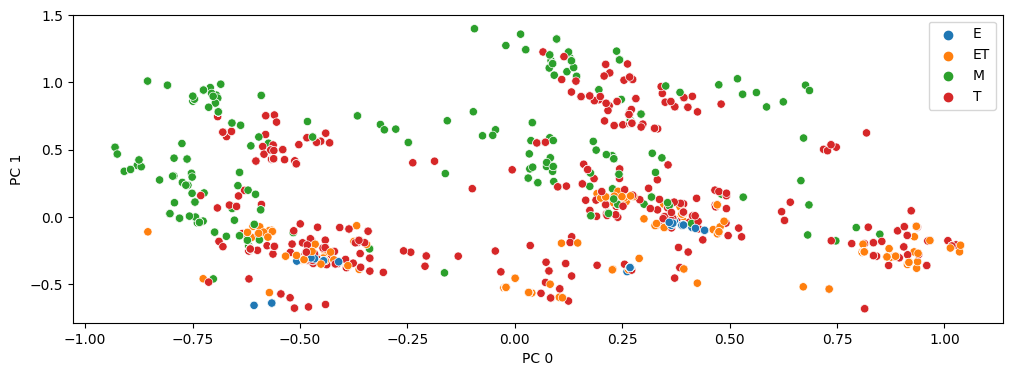

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

sns.scatterplot(x='PC 0', y='PC 1', hue=y, data=X_pca_1, ax=ax)


## Aplicando o classificador Decision Tree usando validação cruzada em dois níveis

In [10]:

params = {
    'min_samples_leaf': [1,2,3, 4,5, 10, 15, 20, 30],
    'min_samples_split': [3, 5, 10, 15, 20, 30],
    'max_depth': [2, 3, 4, 5],
}

arvore_decisao, list_confusion_matrix, list_melhor_comb = do_cv(
    DecisionTreeClassifier, X_pca_1.values, y, 10, 5, 2, False, params,True)

arvorer_dec_params = list_melhor_comb[np.argmax(arvore_decisao)]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           E       0.91      0.69      0.78        42
          ET       0.50      0.62      0.56        40
           M       0.65      0.62      0.63        39
           T       0.61      0.62      0.61        69

    accuracy                           0.64       190
   macro avg       0.67      0.64      0.65       190
weighted avg       0.66      0.64      0.64       190

{'E', 'M', 'ET', 'T'}
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5} -- F1-Score: 0.6429391282853887
              precision    recall  f1-score   support

           E       0.77      0.98      0.86        42
          ET       0.81      0.75      0.78        40
           M       0.81      0.54      0.65        39
           T       0.70      0.75      0.73        69

    accuracy                           0.76       190
   macro avg       0.77      0.75      0.75       190
weighted avg       0.76      0.76      0.75       190

{'E', 'M', '

## Após a aplicação do classificador, percebemos que o modelo obteve os seguintes resultados:

In [11]:
print("Maior valor: ", max(arvore_decisao), "\nMenor valor: ", min(arvore_decisao), "\nMédia: ", np.mean(arvore_decisao), "\nMediana: ", np.median(arvore_decisao), "\nDesvio Padrão: ", np.std(arvore_decisao))
# max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split
print(f'\n\nMelhor combinação de hiperparâmetros da árvore de decisão: \nMaximo de profundidade: {arvorer_dec_params["max_depth"]},  \nMinimo de amostras por folha: {arvorer_dec_params["min_samples_leaf"]}, \nMinimo de amostras para split: {arvorer_dec_params["min_samples_split"]}')
        

Maior valor:  0.7515962154189302 
Menor valor:  0.6429391282853887 
Média:  0.7025034814399164 
Mediana:  0.7041133784599076 
Desvio Padrão:  0.030582190658577337


Melhor combinação de hiperparâmetros da árvore de decisão: 
Maximo de profundidade: 5,  
Minimo de amostras por folha: 2, 
Minimo de amostras para split: 5


## Abaixo temos a matriz de confusão do modelo.

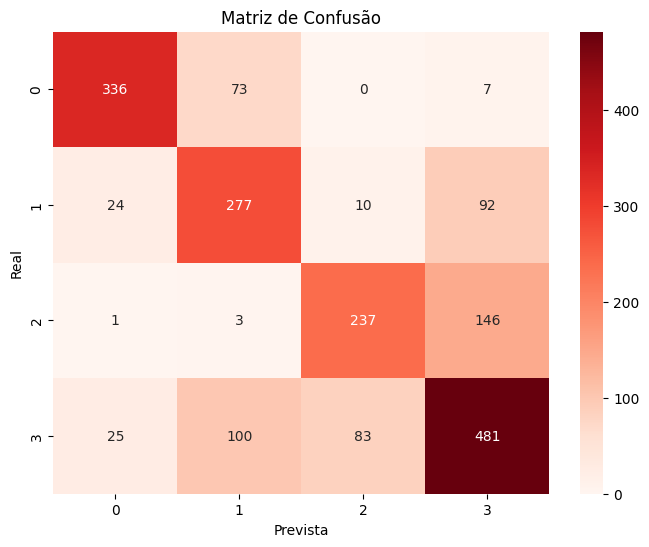

In [12]:
import functools
import seaborn as sns
import matplotlib.pyplot as plt

reduceMatrix = functools.reduce(lambda x, y: x + y, list_confusion_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(reduceMatrix, cmap='Reds', annot=True, fmt='d' )
plt.xlabel('Prevista')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## Utilizando os parâmetros para a arvore de decisão, obtemos a seguinte árvore:

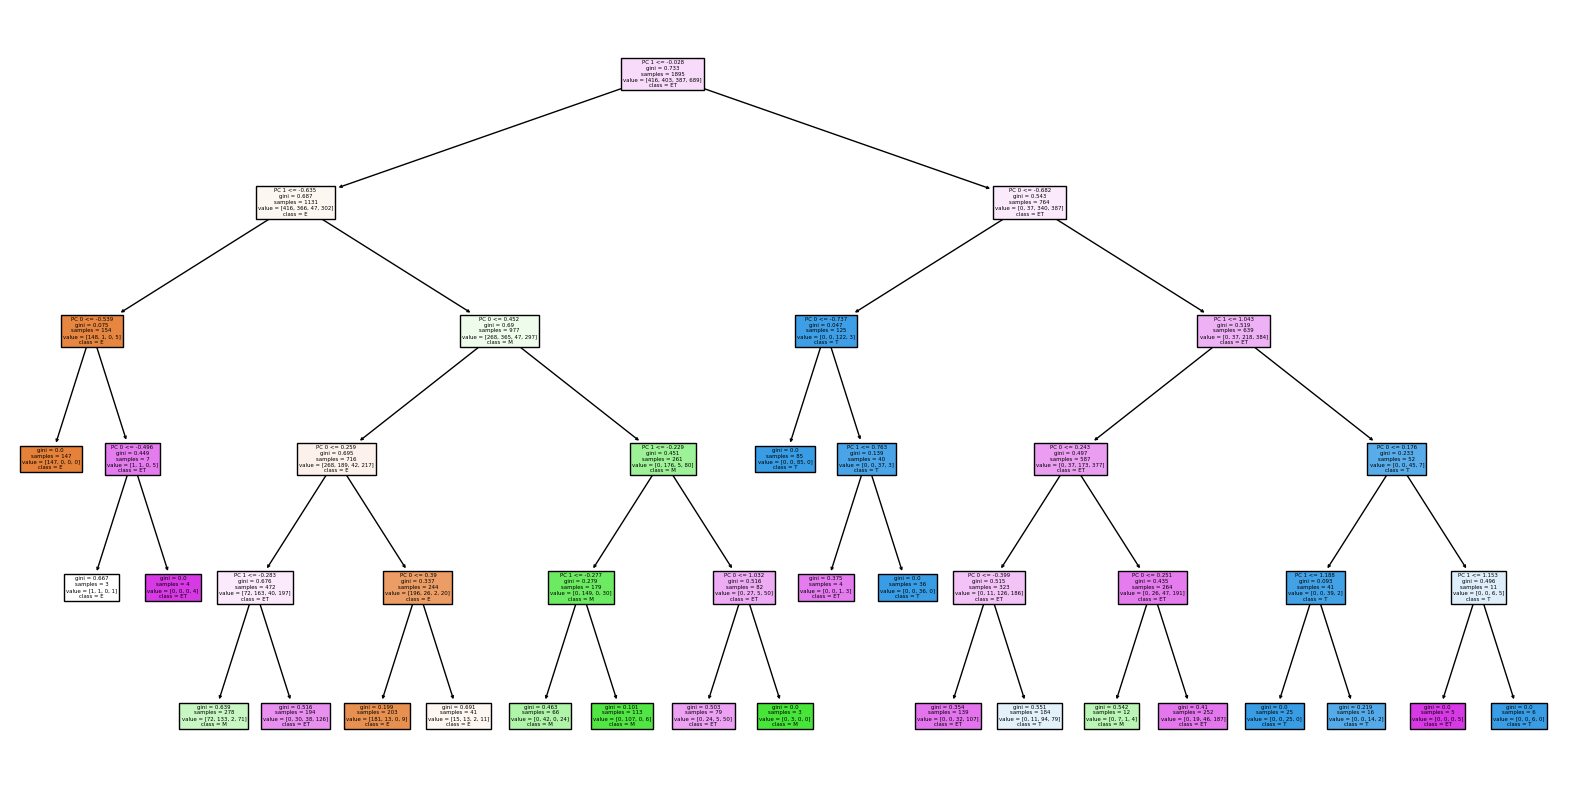

In [13]:
tree = DecisionTreeClassifier(**arvorer_dec_params)
tree.fit(X_pca_1.values, y)

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X_pca_1.columns, class_names=['E', 'M', 'T', 'ET'])
plt.savefig('tree.png', dpi=300)
plt.show()


In [14]:
# F1 score da árvore de decisão induzida pelo algoritmo acima
from sklearn.metrics import f1_score

aninhado = classify_games(X)
aninhado
f1 = f1_score(y, aninhado, average='weighted')

# Fazendo a predição com o modelo treinado, com pesos balanceados, temos a seguinte predição:

In [15]:
from sklearn.metrics import classification_report
print(f'F1 score da árvore de decisão induzida pelo algoritmo acima: {f1}')

print(classification_report(y, aninhado))


F1 score da árvore de decisão induzida pelo algoritmo acima: 0.6298527781654958
              precision    recall  f1-score   support

           E       0.94      0.64      0.76       416
          ET       0.76      0.58      0.66       403
           M       0.73      0.34      0.47       387
           T       0.50      0.82      0.62       689

    accuracy                           0.63      1895
   macro avg       0.73      0.60      0.63      1895
weighted avg       0.70      0.63      0.63      1895



# Analisando a classificação em SVM, KNN e Random Forest 


In [16]:
from sklearn.ensemble import RandomForestClassifier
from utils import imprimir_estatisticas


classifier = [
    SVC,
    KNeighborsClassifier,
    RandomForestClassifier,
 ]
params = [
    {'gamma' : ['auto', 'scale', 2e-2, 2e-3, 2e-4],'C' : [1, 10, 100, 1000], 'kernel': ['rbf']},
    {'n_neighbors' : [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]},
    {'n_estimators' : [100, 250, 500, 700]},
]

results=[]

for i in range(len(classifier)):
    res, a, b = do_cv(classifier[i], X_pca_1.values, y, 10, 5, 2, False, params[i])
    results.append(res)
    imprimir_estatisticas(res, classifier[i].__name__)



Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

TypeError: %d format: a real number is required, not str

# Realizando o Teste-T para verificar se os modelos são estatisticamente diferentes

In [ ]:

len(results)
d, p = rejeitar_hip_nula(results[0], results[1], alpha=0.05)
print(f'p-valor: {p}, d: {d}')

d, p = rejeitar_hip_nula(results[0], results[2], alpha=0.05)
print(f'p-valor: {p}, d: {d}')

d, p = rejeitar_hip_nula(results[1], results[2], alpha=0.05)
print(f'p-valor: {p}, d: {d}')



p-valor: 0.10364659105098925, d: False
p-valor: 0.00013442911018890516, d: True
p-valor: 0.001851784030377952, d: True
